# Objective
*   From the model built in the previous steps, we need now to translate and interpret the results obtained from a business perspective.
*  In this step we will also build an API and deploy it to ensure that the solution can have an impact beyond the local environment





# 1. Library imports

In [ ]:
import math
import numpy as np
import pandas as pd

import inflection
import seaborn as sns
import random
import warnings
from matplotlib import pyplot as plt
from IPython.core.display import HTML
import xgboost as xgb

from scipy import stats as ss
from boruta import BorutaPy
from IPython.core.display import HTML
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder


#Helper Functions

For this section, some helper functions have been created.

*   **cross_validation**: Through this technique, the data are divided into blocks (Folds) and different training/validation combinations are created with these blocks, in order to reduce the chances of getting only one biased combination and, thus, allowing a greater capacity for generalization to our model




In [ ]:
def cross_validation( x_training, kfold, model_name, model, verbose=False ):
  mae_list = []
  mape_list = []
  rmse_list = []
  for k in reversed( range( 1, kfold+1 ) ):
    if verbose:
      print( '\nKFold Number: {}'.format( k ) )
    # start and end date for validatio
    validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)
    validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)
    # filtering dataset
    training = x_training[x_training['date'] < validation_start_date]
    validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]
    # training and validation dataset
    # training
    xtraining = training.drop( ['date', 'sales'], axis=1 )
    ytraining = training['sales']
    # validation
    xvalidation = validation.drop( ['date', 'sales'], axis=1 )
    yvalidation = validation['sales']
    # model
    m = model.fit( xtraining, ytraining )
    # prediction
    yhat = m.predict( xvalidation )
    # performance
    m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1(yhat ) )
    # store performance of each kfold iteration
    mae_list.append( m_result['MAE'] )
    mape_list.append( m_result['MAPE'] )
    rmse_list.append( m_result['RMSE'] )
  return pd.DataFrame( {'Model Name': model_name,
  'MAE CV': np.round( np.mean( mae_list ), 2 ).astype(str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
  'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
  'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str )}, index=[0] )

def mean_percentage_error( y, yhat ):
  return np.mean( ( y - yhat ) / y )

def mean_absolute_percentage_error( y, yhat ):
  return np.mean( np.abs( ( y - yhat ) / y ) )

def ml_error( model_name, y, yhat ):
  mae = mean_absolute_error( y, yhat )
  mape = mean_absolute_percentage_error( y, yhat )
  rmse = np.sqrt( mean_squared_error( y, yhat ) )
  return pd.DataFrame( { 'Model Name': model_name,
  'MAE': mae,
  'MAPE': mape,
  'RMSE': rmse }, index=[0] )

# 2. Business results

First, let's filter the columns. Also, as we previously transformed with logarithm operation to the input in the model, we will now do the inverse

In [ ]:
df9 = X_test[ cols_selected_boruta_full ]
# rescale
df9['sales'] = np.expm1( df9['sales'] )
df9['predictions'] = np.expm1( yhat_xgb_tuned )

To evaluate the results from a business perspective I considered that the prediction could fluctuate between + - the sum of predictions **MAPE (mean absolute percentage error) **for each store. In other words, that the prediction would lie within the range of the MAPE either way (up or down). Thus, the risks are clear

In [ ]:
# sum of predictions
df91 = df9[['store', 'predictions']].groupby( 'store' ).sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply(lambda x: mean_absolute_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply(lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAPE'})

# Merge
df9_aux3 = pd.merge( df9_aux1, df9_aux2, how='inner', on='store' )
df92 = pd.merge( df91, df9_aux3, how='inner', on='store' )

# Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# order columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE','MAPE']]


Below are a few samples of the predictions for the last 6 weeks of sales 

*   With the provision below, we have the forecast, considering the variation in the best and worst scenario in relation to the sales forecast so that the decision on how much to invest in each one can be made.



In [ ]:
df9_1.sample(5, random_state = 42)

,store,sales_prediction,best_scenario,worst_scenario,MAPE,MAE
265,266,"154,721.03","170,340.41","139,101.66",0.100952,409.712158
101,102,"244,210.56","270,188.37","218,232.76",0.106375,752.815984
1045,1046,"307,952.31","336,752.86","279,151.76",0.093523,874.730944
792,793,"171,992.42","190,731.26","153,253.58",0.108952,519.433871
902,903,"329,706.25","414,229.13","245,183.37",0.256358,3143.479980


## 2.1 Total Performance

In [ ]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply( lambda x: np.sum( x ), axis=0 ).reset_index().rename( columns={'index': 'Scenario', 0:'Values'} )
df93['Values'] = df93['Values'].map( 'R${:,.2f}'.format )
df93

,Scenario,Values
0,predictions,"R$285,860,480.00"
1,worst_scenario,"R$285,115,015.78"
2,best_scenario,"R$286,605,979.91"


## 2.2 Machine Learning Performance

In [ ]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

The image below is the performance of our machine learning model:

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


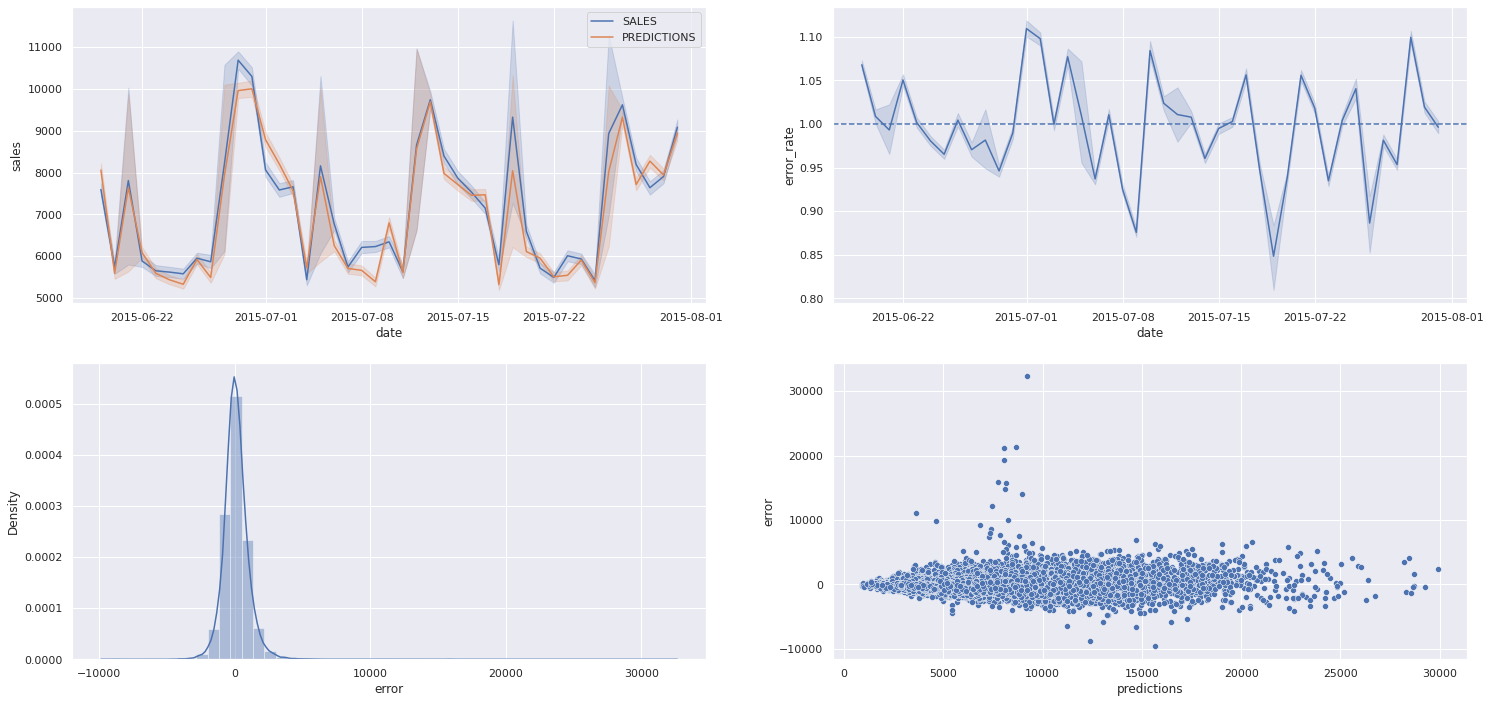

In [ ]:
plt.subplot( 2, 2, 1 )
sns.lineplot( x='date', y='sales', data=df9, label='SALES' )
sns.lineplot( x='date', y='predictions', data=df9, label='PREDICTIONS' )

plt.subplot( 2, 2, 2 )
sns.lineplot( x='date', y='error_rate', data=df9 )
plt.axhline( 1, linestyle='--')

#analise de residuo.. pesquisar:


plt.subplot( 2, 2, 3 )
sns.distplot( df9['error'] )

#erro dentro do tubo!
plt.subplot( 2, 2, 4 )
sns.scatterplot( df9['predictions'], df9['error'] )

From the 4 plots, we can see that, respectively:

*  Sales predictions (orange line) lie well within the real sales, however not close enough to be overfitting.
- The ratio between predictions/actual values is mostly below 1 and therefore, the model is "undershooting" or "underpredicting" the real values a little bit in some periods.
- The errors are normally distributed, which means the model is not committing significant errors when predicting the sales. In other others, the errors are, on average, near zero.
- Errors do not increase as the predicted values increase (there is not much variation in the errors), so the model is not biased for either low or high prediction values.

#3. Deploy Model To Production

Finishing this first iteration in the CRISP cycle I built and deployed three applications to help others use my work:

- A Flask API to receive POST requests with data from a store and return a prediction
- A Telegram bot that replies to the user with the sales prediction for any store the user sends to it
- A Streamlit web app that allows the user to visualize sales predictions of the next six weeks, both graphically and numerically, for any store and compare it to a past time frame so that the user might have an idea if the prediction makes sense or not.

In [ ]:
import pickle 
# Save Trained Model
pickle.dump( model_xgb_tuned, open( '/content/drive/MyDrive/Colab Notebooks/Projetos/rossmann/model_rossmann.pkl', 'wb' ) )


## 3.1 Rossmann Class

In [ ]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime

class Rossmann( object ):

  def __init__( self ):
    self.home_path='/content/drive/MyDrive/Colab Notebooks/Projetos/rossmann'
    self.competition_distance_scaler = pickle.load( open( self.home_path + 'parameter/competition_distance_scaler.pkl', 'rb') )
    self.competition_time_month_scaler = pickle.load( open( self.home_path + 'parameter/competition_time_month_scaler.pkl', 'rb') )
    self.promo_time_week_scaler = pickle.load( open( self.home_path + 'parameter/promo_time_week_scaler.pkl', 'rb') )
    self.year_scaler = pickle.load( open( self.home_path + 'parameter/year_scaler.pkl', 'rb') )
    self.store_type_scaler = pickle.load( open( self.home_path + 'parameter/store_type_scaler.pkl', 'rb') )

  def data_cleaning( self, df1 ):
    ## 1.1. Rename Columns
    cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo','StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance','CompetitionOpenSinceMonth', 
                'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']
    snakecase = lambda x: inflection.underscore( x )
    cols_new = list( map( snakecase, cols_old ) )

    # rename
    df1.columns = cols_new

    ## 1.3. Data Types
    df1['date'] = pd.to_datetime( df1['date'] )

    ## 1.5. Fillout NA
    #competition_distance
    df1['competition_distance'] = df1['competition_distance'].apply( lambda: 200000.0 if math.isnan( x ) else x )

    #competition_open_since_month
    df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )

    #competition_open_since_year
    df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )

    #promo2_since_week
    df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )

    #promo2_since_year
    df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

    #promo_interval
    month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
    df1['promo_interval'].fillna(0, inplace=True )
    df1['month_map'] = df1['date'].dt.month.map( month_map )
    df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x:0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )

    ## 1.6. Change Data Types
    # competiton
    df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
    df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )

    # promo2
    df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
    df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )

    return df1
  
  def feature_engineering( self, df2 ):
    # year
    df2['year'] = df2['date'].dt.year
    # month
    df2['month'] = df2['date'].dt.month

    # day
    df2['day'] = df2['date'].dt.day

    # week of year
    df2['week_of_year'] = df2['date'].dt.weekofyear

    # year week
    df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

    # competition since
    df2['competition_since'] = df2.apply( lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )
    df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

    # promo since
    df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
    df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
    df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

    # assortment
    df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

    # state holiday
    df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

    # 3.0. PASSO 03 - FILTRAGEM DE VARIÁVEIS
    ## 3.1. Filtragem das Linhas
    df2 = df2[df2['open'] != 0]
    ## 3.2. Selecao das Colunas
    cols_drop = ['open', 'promo_interval', 'month_map']
    df2 = df2.drop( cols_drop, axis=1 )
    return df2

  def data_preparation( self, df5 ):
    
    ## 5.2. Rescaling
    # competition distance
    df5['competition_distance'] = self.competition_distance_scaler.fit_transform( df5[['competition_distance']].values )

    # competition time month
    df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform( df5[['competition_time_month']].values )

    # promo time week
    df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform(df5[['promo_time_week']].values )

    # year
    df5['year'] = self.year_scaler.fit_transform( df5[['year']].values )

    ### 5.3.1. Encoding
    # state_holiday - One Hot Encoding
    df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

    # store_type - Label Encoding
    df5['store_type'] = self.store_type_scaler.fit_transform(df5['store_type'] )

    # assortment - Ordinal Encoding
    assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
    df5['assortment'] = df5['assortment'].map( assortment_dict )

    ### 5.3.3. Nature Transformation
    # day of week
    df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
    df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

    # month
    df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
    df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

    # day
    df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
    df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

    # week of year
    df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin(x * ( 2. * np.pi/52 ) ) )
    df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos(x * ( 2. * np.pi/52 ) ) )
    cols_selected = [ 'store', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month',
    'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year', 'competition_time_month', 'promo_time_week',
    'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'week_of_year_sin', 'week_of_year_cos']

    return df5[ cols_selected ]

  def get_prediction( self, model, original_data, test_data ):
    # prediction
    pred = model.predict( test_data )
    # join pred into the original data
    original_data['prediction'] = np.expm1( pred )

    return original_data.to_json( orient='records', date_format='iso' )



## 3.2 API Handler

The handler loads the model in production, receives the data from the API and sends it to the transformations passing to the model, returning the request to whoever requests it.

In [ ]:
import pickle
import pandas as pd
from flask import Flask, request, Response
from rossmann.Rossmann import Rossmann

# loading model
model = pickle.load( open( '/content/drive/MyDrive/Colab Notebooks/Projetos/rossmann/model_rossmann.pkl', 'rb') )

# initialize API
app = Flask( __name__ )
@app.route( '/rossmann/predict', methods=['POST'] )

def rossmann_predict():
  test_json = request.get_json()
  if test_json: # there is data
    if isinstance( test_json, dict ): # unique example
      test_raw = pd.DataFrame( test_json, index=[0] )

    else: # multiple example
      test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )
    # Instantiate Rossmann class
    pipeline = Rossmann()
    # data cleaning
    df1 = pipeline.data_cleaning( test_raw )
    # feature engineering
    df2 = pipeline.feature_engineering( df1 )
    # data preparation
    df3 = pipeline.data_preparation( df2 )
    # prediction
    df_response = pipeline.get_prediction( model, test_raw, df3 )

    return df_response

  else:
  return Reponse( '{}', status=200, mimetype='application/json' )

if __name__ == '__main__':
  app.run( '0.0.0.0' )


## 3.3 API Testing

In [ ]:
# Loading new unused data for testing
df_store_raw = pd.read_csv('../data/store.csv', low_memory = False)
df_test_raw = pd.read_csv('../data/test.csv', low_memory = False)

# Merging test dataset with store dataset
df_test = pd.merge( df_test_raw, df_store_raw, how = 'left', on = 'Store' )

# Selecting a few stores
#df_test = df_test.loc[ df_test['Store'].isin( [1, 50, 500, 1000] ) ]

# Droping closed days and Id column
df_test = df_test.loc[ df_test['Open'] != 0 ]
df_test.drop( 'Id', axis = 1, inplace = True)
# Converting data to json
data = df_test.to_json( orient = 'records' )


In [ ]:
# Calling API Locally

url = 'http://0.0.0.0:5000/rossmann/predict'
header = {'Content-type' : 'application/json'}
data = data

r = requests.post( url, data = data, headers = header )

print( 'Status Code {}'.format( r.status_code ) )

In [ ]:
# Sampling 5 predictions
res = pd.DataFrame.from_dict( r.json() )
res.sample(5, random_state= 42)

,store,day_of_week,date,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week,year_week,competition_since,competition_time_months,promo2_in_weeks,sales_prediction,MAPE
13810,434,5,2015-08-07T00:00:00.000Z,1.0,1,regular_day,1,a,basic,13020.0,8,2003,1,40,2014,"Jan,Apr,Jul,Oct",Aug,0,2015,8,7,32,2015-31,2003-08-01T00:00:00.000Z,146,44,10072.339844,0.133429
22107,697,2,2015-08-04T00:00:00.000Z,1.0,1,regular_day,1,d,basic,3780.0,8,2015,1,40,2011,"Jan,Apr,Jul,Oct",Aug,0,2015,8,4,32,2015-31,2015-08-01T00:00:00.000Z,0,201,11592.302734,0.073753
27550,872,3,2015-08-26T00:00:00.000Z,1.0,0,regular_day,0,a,extended,3860.0,9,2014,1,23,2015,"Mar,Jun,Sept,Dec",Aug,0,2015,8,26,35,2015-34,2014-09-01T00:00:00.000Z,11,12,6759.966309,0.099510
15987,509,6,2015-08-01T00:00:00.000Z,1.0,0,regular_day,1,a,basic,4740.0,7,2008,1,37,2009,"Jan,Apr,Jul,Oct",Aug,0,2015,8,1,31,2015-30,2008-07-01T00:00:00.000Z,86,307,4229.008789,0.071529
16171,515,3,2015-09-02T00:00:00.000Z,1.0,1,regular_day,0,d,extended,11260.0,9,2015,1,9,2011,"Feb,May,Aug,Nov",Sep,0,2015,9,2,36,2015-35,2015-09-01T00:00:00.000Z,0,236,9386.853516,0.080796


In [ ]:
# Calling API deployed to Heroku

url = 'https://rossmann-xgb-api.herokuapp.com/rossmann/predict'
header = {'Content-type' : 'application/json'}
data = data

r = requests.post( url, data = data, headers = header )

print( 'Status Code {}'.format( r.status_code ) )

Status Code 200


In [ ]:
json_data = r.json()
df_mape = pd.read_pickle( open('/home/humberto/DS/Rossmann/parameters/df_mape.pkl', 'rb' ) )

# creating results df
res = pd.DataFrame.from_dict( json_data )
# res

res = res[[ 'store', 'sales_prediction']].groupby('store').sum().reset_index()
res = res.merge( df_mape, how = 'inner', on = 'store' )
res['best_scenario'] = res['sales_prediction'] + res['sales_prediction']*res['MAPE'] 
res['worst_scenario'] = res['sales_prediction'] - res['sales_prediction']*res['MAPE'] 
res['uncertainty'] = res['sales_prediction']*res['MAPE'] 

In [ ]:
res

,store,sales_prediction,MAPE,best_scenario,worst_scenario,uncertainty
0,1,186332.133057,0.100289,205019.124171,167645.141943,18686.991114


## 3.4 Telegram BOT

In [ ]:
# rossmann_bot_telegram.py file

import pandas as pd
import requests
import json
import os
from flask import Flask, request, Response

token_json = open('token.json')
token = json.load(token_json)
token = token['token']

# send message to user
def send_message( chat_id, message ):
    # defining url to send message through requests
    url = 'https://api.telegram.org/bot{}/'.format( token ) 
    url = url + 'sendMessage?chat_id={}'.format( chat_id ) 
    
    r = requests.post( url, json = {'text' : message} )
    print( 'Status code {}'.format( r.status_code ) )
    
    return None

# Loading new unused data for testing
def data_preprocessing( store_id ):
    # read raw dataset
    store_id = int(store_id)
    df_store_raw = pd.read_csv('store.csv', low_memory = False)
    df_test_raw =  pd.read_csv('test.csv', low_memory = False)

    # Merging test dataset with store dataset
    df_test = pd.merge( df_test_raw, df_store_raw, how = 'left', on = 'Store' )
           
    # Selecting a store
    df_test = df_test[ df_test['Store'] == store_id  ].copy() #, 500, 1000

    # Check if store_id is valid
    if not df_test.empty:
        
        # Droping closed days and Id column
        df_test = df_test.loc[ df_test['Open'] != 0 ].copy()
        df_test.drop( 'Id', axis = 1, inplace = True)
        # Converting data to json
        json_data  = json.dumps( df_test.to_dict('records') )
    else:
        json_data = 'store_doesnt_exist'

    return json_data

def call_api( json_data ):
    # Calling API on Heroku
    url = 'https://rossmann-xgb-api.herokuapp.com/rossmann/predict'
    header = {'Content-type' : 'application/json'}

    response = requests.post( url, data = json_data, headers = header )

    print( 'Status Code {}'.format( response.status_code ) )
    api_response = response.json()
    return api_response

def eval_result( api_response ):
    df_mape = pd.read_pickle( open('df_mape.pkl', 'rb' ) )

    # creating results df
    res = pd.DataFrame.from_dict( api_response )

    res = res[['store', 'sales_prediction']].groupby('store').sum().reset_index()
    res = res.merge( df_mape, how = 'inner', on = 'store' )
    res['best_scenario'] = res['sales_prediction'] + res['sales_prediction']*res['MAPE'] 
    res['worst_scenario'] = res['sales_prediction'] - res['sales_prediction']*res['MAPE'] 
    res['uncertainty'] = res['sales_prediction']*res['MAPE'] 

    return res

def parse_message( message_received ):
    chat_id = message_received['message']['from']['id']
    store_id = message_received['message']['text']

    #store_id = store_id.replace('/', '')
    try:
        store_id = int( store_id )
    except ValueError:
        store_id = 'error'
    return chat_id, store_id

# API
app = Flask(__name__)

@app.route( '/', methods = ['GET', 'POST'] )
def index():
    
    # if a message is received
    if request.method == 'POST':
        message_received = request.get_json()
        
        chat_id, store_id = parse_message( message_received )

        # check if store_id is a number 
        if store_id != 'error':
            json_data = data_preprocessing( store_id )
            
            #check if store_id in dataframe and return prediction
            if json_data != 'store_doesnt_exist':
                
                # call xgb model API 
                api_response = call_api( json_data )
                
                # evaluate result and uncertainty 
                res = eval_result( api_response )
                
                # define all result variables that will be displayed to user
                pred = res['sales_prediction'][0]
                high_range = res['best_scenario'][0]
                low_range = res['worst_scenario'][0]

                # sends result as message to user
                send_message( chat_id, 'Store {} sales for next 6 weeks estimated at: $ {:,.2f}'.format(store_id, pred) )
                send_message( chat_id, 'Prediction might vary from $ {:,.2f} to $ {:,.2f}'.format(low_range, high_range) )
                return Response( 'Ok', status = 200 )
            
            else: #store_id not found in DF
                send_message( chat_id, "Store {} doesn't exist".format(store_id) )
                return Response( 'Ok', status = 200)
            
        # if store_id not valid, return status = 200 to exit  API loop  
        else:
            send_message( chat_id, 'Store ID not understood' )
            return Response( 'Ok', status = 200)
    
    # bot html welcome
    else:
        return '<h1> Rossman Stores Telegram BOT </h1>'

if __name__ == '__main__':
    # app.run( host='0.0.0.0', port=5000 )
    
    port = os.environ.get( 'PORT', 5000 )
    app.run( host = '0.0.0.0', port = port )
    

## 3.5 Streamlit APP

In [ ]:
import pandas as pd
import requests
import json
from PIL import Image
import streamlit as st

# Recieves dataframe,requests prediction to API and returns predictions as dataframe
@st.cache(allow_output_mutation=True)
def call_api( data ):
    # Transform data to json format
    data = json.dumps( data.to_dict('records') )

    #Call api
    url = 'https://rossmann-xgb-api.herokuapp.com/rossmann/predict'
    header = {'Content-type' : 'application/json'}
    data = data
    r = requests.post( url, data = data, headers = header )

    # Return status and data
    print( 'Status Code {}'.format( r.status_code ) )
    json_data = r.json()
    df = pd.DataFrame.from_dict( json_data )
    return df

# Receives selected period and returns train dataset (with sales and customers columns)
@st.cache(allow_output_mutation=True)
def select_train_df(period):
    global train
    train_df = train.loc[ train['Open'] != 0 ]

    train_dates = train_df['Date'].unique().tolist()
    train_dates.reverse()
    if period == '2014':
        min_date = test_dates[0].replace('2015', '2014')
        max_date = test_dates[-1].replace('2015', '2014')
    elif period == '2013':
        min_date = test_dates[0].replace('2015', '2014')
        max_date = test_dates[-1].replace('2015', '2014')
    else:
        min_date = train_dates[0]
        max_date = train_dates[-1]
    train_df = train_df.loc[ (train_df['Date'] >= min_date) & 
                             (train_df['Date'] < max_date) & 
                             (train_df['Store'].isin(stores_multiselect) ) ]

    train_df = pd.merge( train_df, df_store_raw, how = 'left', on = 'Store' )
    return train_df

# Calculates sales prediction expected error / uncertainty from predictions dataset
@st.cache(allow_output_mutation=True)
def result_calculation(predictions_dataset):
    res = predictions_dataset[[ 'store', 'sales_prediction', 'MAPE']].copy()
    res['best_scenario'] = res['sales_prediction']  + res['sales_prediction']*res['MAPE']
    res['worst_scenario'] = res['sales_prediction'] - res['sales_prediction']*res['MAPE']
    res['uncertainty'] = res['sales_prediction']*res['MAPE']
    res = res.groupby('store').sum().reset_index()
    res.drop('MAPE', axis =1, inplace = True)
    res = res.rename( columns = {'store': 'Store',	'sales_prediction': 'Sales Prediction',	'best_scenario': 'Best Scenario', 'worst_scenario': 'Worst Scenario', 'uncertainty': 'Uncertainty'} )
    return res

# ---------------------------------- #
# Loading objects

# Loading train datasets
train = pd.read_csv('train.csv', low_memory = False)

# Loading dataset to predict sales
df_store_raw = pd.read_csv('store.csv', low_memory = False)
df_test_raw =  pd.read_csv('test.csv',  low_memory = False)

# Merging test dataset with store dataset
df_test = pd.merge( df_test_raw, df_store_raw, how = 'left', on = 'Store' )

stores = df_test['Store'].unique();
test_dates = df_test['Date'].unique().tolist()
test_dates.reverse()

image = Image.open('Rossmann_logo.jpg')

# ---------------------------------- #
# Defining sidebar widgets
st.sidebar.write('#### Select a store:')
stores_multiselect = st.sidebar.multiselect('', stores)
st.sidebar.write('#### Select a period to compare predictions:')
period = st.sidebar.selectbox('',
        ['2014', '2013', 'Entire dataset'] )

toogle_all = st.sidebar.checkbox('Show all stores predictions dataset', value = False)

# ---------------------------------- #
# Ploting predictions for a store

"""
# Rossmann Stores Sales Predictions 
"""

if stores_multiselect != []:
    # Selecting desired store
    df_test = df_test.loc[ df_test['Store'].isin( stores_multiselect ) ]

    # Droping closed days and Id column
    df_test = df_test.loc[ df_test['Open'] != 0 ] 
    df_test.drop( 'Id', axis = 1, inplace = True)

    # Caling API
    ds_pred = call_api( df_test )

    # Calculating Results
    result = result_calculation(ds_pred)

    # Ploting result table
    st.write('## Sales Prediction for store: {} in next 6 weeks'.format(stores_multiselect[0]) )
    st.table(result.style.format( {'Sales Prediction' : '{:,.2f}',
                                            "Best Scenario" : "{:,.2f}",
                                            "Worst Scenario" : "{:,.2f}",
                                            "Uncertainty" : "{:,.2f}"} ))

    #creating dataset to plot

    """
    ## Sales Prediction Chart
    """

    pred_plot = ds_pred[['date', 'sales_prediction']].copy()
    pred_plot['date'] = pd.to_datetime( pred_plot['date'] )
    pred_plot = pred_plot.rename( columns= {'date': 'index'}).set_index('index')
    st.line_chart( pred_plot )

    # ---------------------------------- #
    # Plot predictions for a period in past
    
    if period in ['2014', '2013']:
        st.write('## Actual Sales X Prediction Chart for the same period in {}'.format(period) )
    else:
        st.write('## Actual Sales X Prediction Chart for the {}'.format(period))

    # Selecting period
    train_df = select_train_df(period)
    train_drop = train_df.drop(['Sales', 'Customers'], axis = 1).copy()
    # Caling API
    train_pred = call_api( train_drop )

    # Creating dataset to plot
    train_plot = train_df[['Date', 'Sales']]
    train_plot['Sales Prediction'] = train_pred['sales_prediction']
    train_plot['Date'] = pd.to_datetime( train_plot['Date'])
    train_plot = train_plot.rename( columns = {'Date' : 'index', 'Sales' : 'Actual Sales'} ).set_index('index')

    st.line_chart(train_plot)

    # ---------------------------------- #
    # Ploting prediction results for all stores in test dataset

    """
    ## Expected Total Revenue: 
    """


    # Selecting all  stores
    df_test_all_stores = pd.merge( df_test_raw, df_store_raw, how = 'left', on = 'Store' )

    # Droping closed days and Id column
    df_test_all_stores = df_test_all_stores.loc[ df_test_all_stores['Open'] != 0 ] 
    df_test_all_stores.drop( 'Id', axis = 1, inplace = True)

    # Caling API
    ds_pred_all_stores = call_api( df_test_all_stores )

    all_stores = result_calculation( ds_pred_all_stores )
    #all_stores.drop('Store', axis = 1, inplace = True)
    all_stores = all_stores.sum().reset_index().T
    all_res = all_stores.iloc[1:2, 1:5]
    all_res.columns = all_stores.iloc[0,1:5]
    all_res = all_res.astype('float64')
    st.table(all_res.style.format("{:,.2f}") )

    # Plot Expected Revenue Revenue 
    """
    ### Expected Revenue Chart: 
    """

    all_plot = ds_pred_all_stores[['date','sales_prediction']].groupby('date').sum().reset_index()
    all_plot['date'] = pd.to_datetime(all_plot['date'])
    all_plot = all_plot.rename(columns={ 'date' : 'index', 'sales_prediction' : 'Sales Prediction' } ).set_index('index')
    st.line_chart( all_plot )

    if toogle_all :
        st.write( '### All Stores Sales Predictions' )
        st.write( "##### Explore dataset by clicking on the columns' names" )
        explore = ds_pred_all_stores[['store', 'sales_prediction']].groupby('store').sum().reset_index()
        aux = ds_pred_all_stores[['store_type', 'assortment', 'store', 'competition_distance']].groupby('store').last().reset_index()
        final = explore.merge( aux, how = 'inner', on = 'store' )
        final = final.rename(columns = { 'store': 'Store', 'sales_prediction': 'Sales Prediction', 'store_type' : 'Store Type', 'assortment' : 'Assortment', 'competition_distance' : 'Competition Distance' })
        st.dataframe( final.style.format( {"Sales Prediction" : "{:,.2f}", "Competition Distance" : "{}" } ) ) #precision = 2

else:
    st.write('')
    st.write('### Select a store on the options box to the left and start exploring')
    st.write('')
    st.write('')
    st.image( image )

st.write( '###### App designed by: Matheus de Oliveira Magrin' )
st.write( '###### Find me through [LinkedIn](https://www.linkedin.com/in/mattmagrin)')
